# <font color="yellow">Tabla de Contenido 📋

* [Descripción del Conjunto de Datos](#h1)

    * [Importación de Datos](#h1-1)
    
    * [Preparación de Datos y Extracción de Características](#h1-2)
    
    * [Preprocesamiento de Texto y Embeddings](#h1-3)
    
    * [División del Conjunto de Datos](#h1-4)

* [Entrenamiento del Modelo LSTM](#h2)

    * [Preparación de Entradas](#h2-1)
    
    * [Construcción del Modelo LSTM](#h2-2)
    
    * [Ajuste de Hiperparámetros](#h2-3)
    
    * [Comparación de Hiperparámetros](#h2-4)
    
    * [Análisis de Resultados](#h2-5)

# <font color="yellow"> Descripción del Conjunto de Datos <a class="anchor"  id="h1"></a>

El conjunto de datos comprende 7613 tweets, cada uno etiquetado como tweet relacionado con un desastre o como un tweet que no es un desastre. Contiene el texto, la ubicación, una palabra clave y si es que fueron reales o no.

## Importación de Datos <a class="anchor"  id="h1-1"></a>

In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv("train.csv", index_col='id')
df

,keyword,location,text,target
id,,,,
1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...
10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1


## Preparación de Datos y Extracción de Características <a class="anchor"  id="h1-2"></a>

### Target

Para empezar, analizamos la distribución objetivo de clases utilizando un diagrama gráfico que se muestra en la Figura 1.

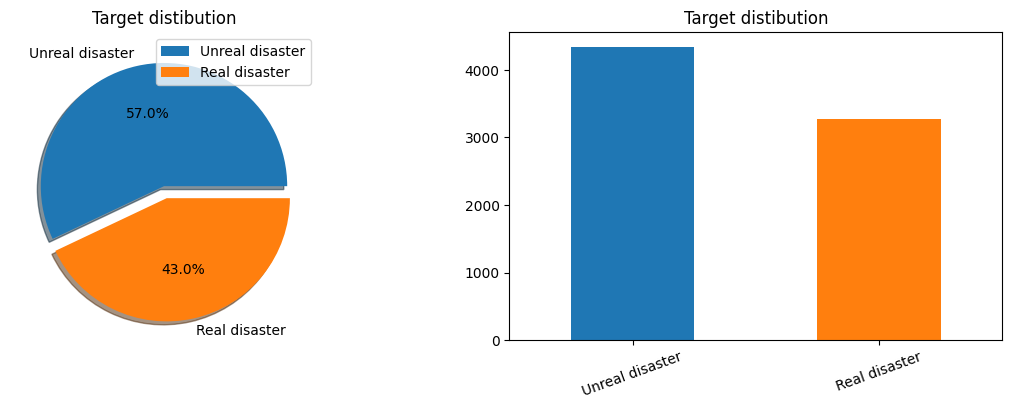

In [4]:
import matplotlib.pyplot as plt

f,ax=plt.subplots(1,2,figsize=(14,4))
target = df['target'].value_counts().rename({0:'Unreal disaster', 1:'Real disaster'})

target.plot.pie(explode=[0,0.1],autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title('Target distibution')
ax[0].set_ylabel('')
ax[0].legend(prop={'size': 10})

target.plot.bar(ax=ax[1], color=['tab:blue', 'tab:orange'], rot=20)
ax[1].set_title('Target distibution')
plt.show()

En este análisis, se destaca un equilibrio en el conjunto de datos: un 57% corresponde a desastres y un 43% a situaciones que no son desastres. Esto es beneficioso para entrenar y evaluar el modelo PNL.


### Keyword

La mayoría de las publicaciones en el conjunto de datos contienen una palabra clave, y solo 61 publicaciones no tienen ninguna palabra clave. En ocasiones, estas palabras clave pueden estar compuestas de varias palabras separadas por espacios. El conjunto de datos incluye un total de 222 palabras clave únicas, cuya distribución de frecuencia se muestra en la Figura 2.

In [7]:
keywords = df['keyword'].value_counts(dropna=False)
keywords

NaN                      61
fatalities               45
deluge                   42
armageddon               42
sinking                  41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: keyword, Length: 222, dtype: int64

#### Figura 2

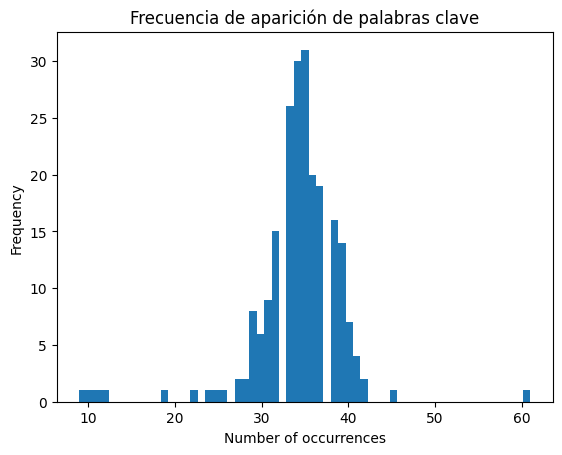

In [8]:
f,ax=plt.subplots()
keywords.plot.hist(ax=ax, bins=61)
ax.set_title('Frecuencia de aparición de palabras clave')
ax.set_xlabel('Number of occurrences')
plt.show()

La Figura 3 muestra un histograma que muestra la proporción de publicaciones que discuten desastres reales para cada palabra clave.

#### Figura 3

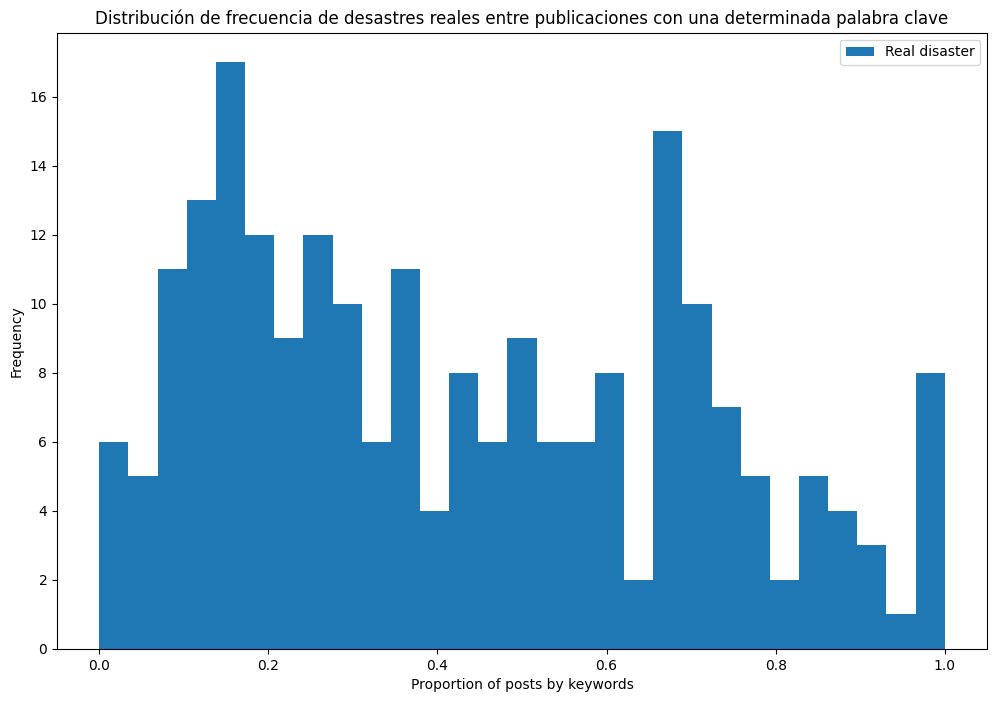

In [5]:
keywords_groupby_target = df.groupby('keyword')['target'].value_counts()
share_unreal_disasters, share_real_disasters = [], []

for keyword in df['keyword'].dropna().unique():
    keyword_value = keywords_groupby_target[keyword]
    sum_count = 0
    for target in keyword_value.index.tolist():
        sum_count += keyword_value[target]
    if 0 in keyword_value:
        share_unreal_disasters.append(keyword_value[0] / sum_count)
        share_real_disasters.append(1 - keyword_value[0] / sum_count)
    else:
        share_unreal_disasters.append(0)
        share_real_disasters.append(1)

bins = np.linspace(0, 1, 30)
f,ax=plt.subplots(figsize=(12,8))
plt.hist(share_real_disasters, bins, label=['Real disaster'])
plt.legend(loc='upper right')
ax.set_title('Distribución de frecuencia de desastres reales entre publicaciones con una determinada palabra clave')
ax.set_xlabel('Proportion of posts by keywords')
ax.set_ylabel('Frequency')
plt.show()

Según las pruebas, podemos concluir que la variable palabra clave es una característica útil para predecir desastres reales. Por lo tanto, el uso de estas palabras puede ayudar a mejorar la precisión del modelo.

### Location

Se encontró que la variable “location” está muy sucia y contiene varias entradas únicas. Por dicha razón, se aplicaron técnicas de limpieza, se eliminaron todos los caracteres no latinos, los nombres se convirtieron en minúscula, etc. Además, los nombres de los países se estandarizaron reemplazando diferentes formatos con sus correspondientes abreviaturas, como "us" y "united states" siendo reemplazados por "usa", y "reino unido" e "inglaterra" por "uk".

In [ ]:
locations = df['location'].value_counts(dropna=False)
locations

NaN                             2533
USA                              104
New York                          71
United States                     50
London                            45
                                ... 
Surulere Lagos,Home Of Swagg       1
MontrÌ©al, QuÌ©bec                 1
Montreal                           1
ÌÏT: 6.4682,3.18287                1
Lincoln                            1
Name: location, Length: 3342, dtype: int64

In [ ]:
import re
import string

def clean_location(text: str):
    result = re.sub(r'[^A-Za-z\s]', ' ', text)
    result = ' '.join([w for w in result.split() if len(w)>1])
    result = re.sub(' +', ' ', result)
    result = result.strip().lower()
    result = re.sub(r'(^|\s)(us|united states)($|\s)', ' usa ', result)
    result = re.sub(r'(^|\s)(united kingdom|england)($|\s)', ' uk ', result)
    return result.strip().lower()

df['location'] = df.apply(lambda row: pd.NA if pd.isna(row['location']) else clean_location(row['location']), axis=1)
locations = df['location'].value_counts(dropna=False)
locations

<NA>              2533
usa                166
                   146
new york            78
london              51
                  ... 
beirut lebanon       1
el paso texas        1
qosqo                1
lubbock tx           1
lincoln              1
Name: location, Length: 2908, dtype: int64

Como resultado, las ubicaciones contienen 2533 valores faltantes y hay 2908 ubicaciones únicas en el conjunto de datos. Las Figuras 4 y 5 muestran la distribución de frecuencia de aparición de nombres de ubicaciones.

#### Figuras 4-5

/tmp/ipykernel_27/1530449069.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

  locations_count.groupby('bins').sum()['count'].plot.pie(autopct='%1.1f%%',ax=ax[0], shadow=True)


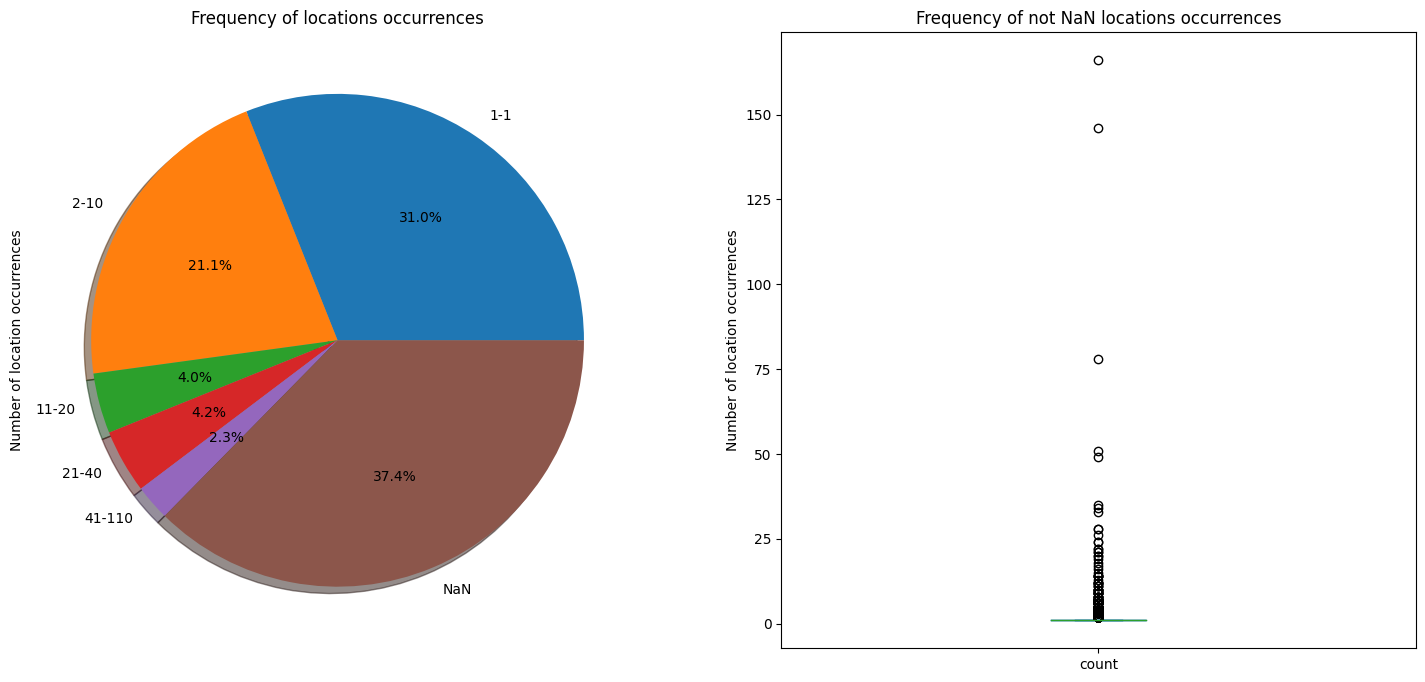

In [ ]:
f,ax=plt.subplots(1,2, figsize=(18,8))

bins=[0, 1, 10, 20, 40, 110, 2533]
locations_count = pd.DataFrame(locations)
locations_count['bins'] = pd.cut(locations, bins=bins, labels=['NaN' if bins[i+1] == 2533 else f'{bins[i] + 1}-{bins[i+1]}' for i in range(len(bins) - 1)])
locations_count.groupby('bins').sum()['count'].plot.pie(autopct='%1.1f%%',ax=ax[0], shadow=True)
ax[0].set_title('Frequency of locations occurrences')
ax[0].set_ylabel('Number of location occurrences')

df['location'].value_counts().plot.box(ax=ax[1])
ax[1].set_title('Frequency of not NaN locations occurrences')
ax[1].set_ylabel('Number of location occurrences')
plt.show()

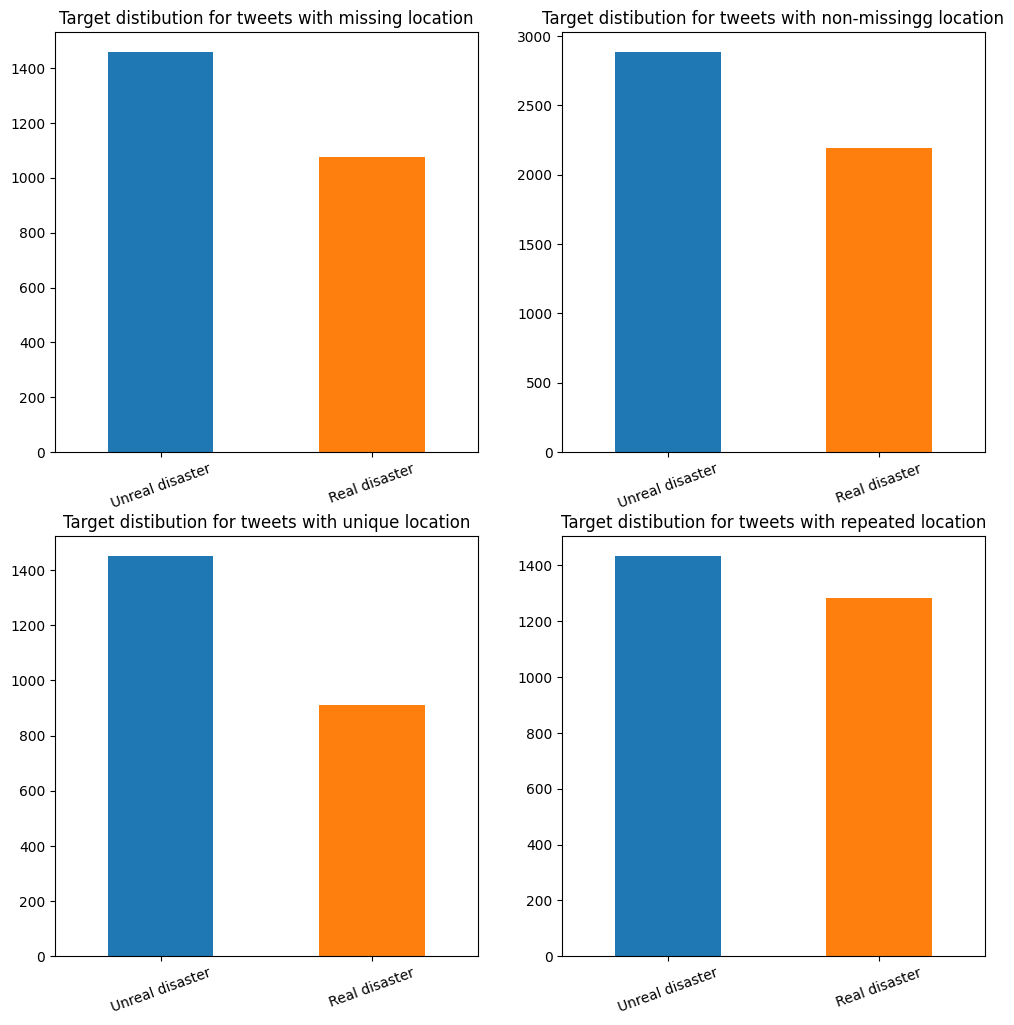

In [ ]:
f,ax=plt.subplots(2,2,figsize=(12,12))

location_isna_target = df[df['location'].isna()]['target'].value_counts().rename({0:'Unreal disaster', 1:'Real disaster'})
location_isna_target.plot.bar(ax=ax[0, 0], color=['tab:blue', 'tab:orange'], rot=20)
ax[0, 0].set_title('Target distibution for tweets with missing location')

location_notna_target = df[df['location'].notna()]['target'].value_counts().rename({0:'Unreal disaster', 1:'Real disaster'})
location_notna_target.plot.bar(ax=ax[0, 1], color=['tab:blue', 'tab:orange'], rot=20)
ax[0, 1].set_title('Target distibution for tweets with non-missingg location')

df_location_unique = df[df['location'].isin(df['location'].value_counts()[df['location'].value_counts() == 1].index)]
location_unique = df_location_unique['target'].value_counts().rename({0:'Unreal disaster', 1:'Real disaster'})
location_unique.plot.bar(ax=ax[1, 0], color=['tab:blue', 'tab:orange'], rot=20)
ax[1, 0].set_title('Target distibution for tweets with unique location')

df_often_locations = df[df['location'].isin(df['location'].value_counts()[df['location'].value_counts() > 1].index)]
often_locations = df_often_locations['target'].value_counts().rename({0:'Unreal disaster', 1:'Real disaster'})
often_locations.plot.bar(ax=ax[1, 1], color=['tab:blue', 'tab:orange'], rot=20)
ax[1, 1].set_title('Target distibution for tweets with repeated location')

plt.show()

Por ejemplo en esa figura, la distribución objetivo está equilibrada para todos los sectores que se muestran. Por lo tanto, la característica de ubicación no es informativa y no será utilizada por nuestro modelo.

### Text

Para realizar un análisis exhaustivo se extrajeron múltiples características y se encontró que los tweets que se escriben de manera más formal son más propensos a ser desastres reales. Además, todas las características extraídas cuentan con correlación con la variable target, por lo que sugiere posible relevancia para predecir presencia de tweets relacionados con desastre.

In [ ]:
from nltk.corpus import stopwords
import nltk

nltk.download('stopwords')
STOP_WORDS = stopwords.words("english")


def get_words(text):
    text = str(text).lower()
    text = re.sub(r'http\S+', ' ', text)
    text = re.sub("\d+", " ", text)
    return [s for s in re.split("\W+", text) if len(s) > 0]


def extract_features_from_text(df):
    df['word_count'] = df['text'].apply(lambda x: len(get_words(x)))
    df['unique_word_count'] = df['text'].apply(lambda x: len(set(get_words(x))))
    df['stop_word_count'] = df['text'].apply(lambda x: len([w for w in get_words(x) if w in STOP_WORDS]))
    df['average_word_length'] = df['text'].apply(lambda x: np.around(np.mean([len(w) for w in get_words(x)]), 1))
    df['text_length'] = df['text'].apply(lambda x: len(str(x)))
    df['punctuation_count'] = df['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
    df['url_link_count'] = df['text'].apply(lambda x: len(re.findall('http[s]?://(?:[-\w.]|(?:%[\da-fA-F]{2}))+', str(x))))
    df['hashtag_count'] = df['text'].apply(lambda x: len(re.findall('(^|\W)#', str(x))))
    df['mention_count'] = df['text'].apply(lambda x: len(re.findall('(^|\W)+@', str(x))))
    return df

df = extract_features_from_text(df)
df

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,keyword,location,text,target,word_count,unique_word_count,stop_word_count,average_word_length,text_length,punctuation_count,url_link_count,hashtag_count,mention_count
id,,,,,,,,,,,,,
1,NaN,<NA>,Our Deeds are the Reason of this #earthquake M...,1,13,13,6,4.3,69,1,0,1,0
4,NaN,<NA>,Forest fire near La Ronge Sask. Canada,1,7,7,0,4.4,38,1,0,0,0
5,NaN,<NA>,All residents asked to 'shelter in place' are ...,1,22,18,11,5.0,133,3,0,0,0
6,NaN,<NA>,"13,000 people receive #wildfires evacuation or...",1,7,7,1,7.1,65,2,0,1,0
7,NaN,<NA>,Just got sent this photo from Ruby #Alaska as ...,1,16,15,7,4.4,88,2,0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10869,NaN,<NA>,Two giant cranes holding a bridge collapse int...,1,10,10,2,5.1,83,5,1,0,0
10870,NaN,<NA>,@aria_ahrary @TheTawniest The out of control w...,1,20,16,9,5.1,125,5,0,0,2
10871,NaN,<NA>,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,7,7,3,3.1,65,11,1,0,0


In [ ]:
df.to_csv('preprocessed-data.csv')

#### Figura 6

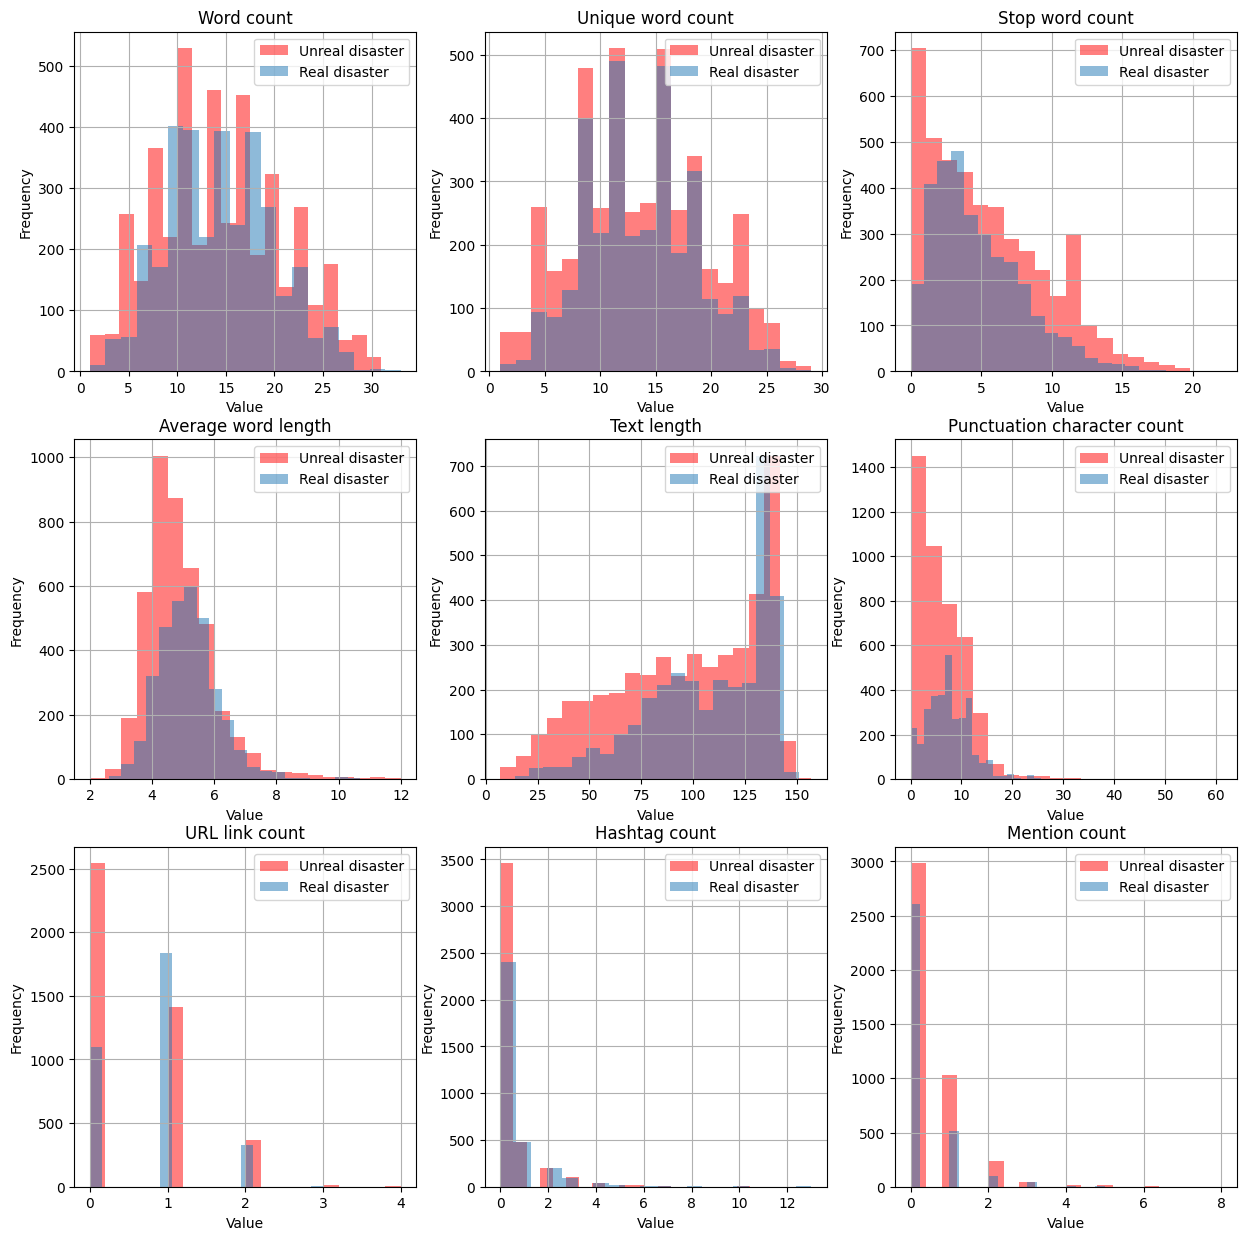

In [ ]:
f,ax = plt.subplots(3, 3,figsize=(15,15))

FEATURES = [('word_count', 'Word count'), ('unique_word_count', 'Unique word count'), ('stop_word_count', 'Stop word count'),
            ('average_word_length', 'Average word length'), ('text_length', 'Text length'), ('punctuation_count', 'Punctuation character count'),
            ('url_link_count', 'URL link count'), ('hashtag_count', 'Hashtag count'), ('mention_count', 'Mention count')
           ]

for i, value in enumerate(FEATURES):
    feature, title = value

    df[df['target'] == 0][feature].hist(ax=ax[i // 3, i % 3], bins=20, alpha=0.5, label='Unreal disaster', color='red')
    df[df['target'] == 1][feature].hist(ax=ax[i // 3, i % 3], bins=20, alpha=0.5, label='Real disaster')
    ax[i // 3, i % 3].set_title(title)
    ax[i // 3, i % 3].set_ylabel('Frequency')
    ax[i // 3, i % 3].set_xlabel('Value')
    ax[i // 3, i % 3].legend(loc='upper right')

plt.show()

In [ ]:
NORMALIZED_COLUMNS = list(df.columns[4:])

for column in NORMALIZED_COLUMNS:
    df[column] = (df[column] - df[column].mean()) / df[column].std()

df

,keyword,location,text,target,word_count,unique_word_count,stop_word_count,average_word_length,text_length,punctuation_count,url_link_count,hashtag_count,mention_count
id,,,,,,,,,,,,,
1,NaN,<NA>,Our Deeds are the Reason of this #earthquake M...,1,-0.214038,-0.093710,0.240620,-0.649600,-0.948377,-1.267041,-0.934019,0.507241,-0.501508
4,NaN,<NA>,Forest fire near La Ronge Sask. Canada,1,-1.208830,-1.202931,-1.340144,-0.553234,-1.866044,-1.267041,-0.934019,-0.404595,-0.501508
5,NaN,<NA>,All residents asked to 'shelter in place' are ...,1,1.278151,0.830641,1.557924,0.024962,0.946161,-0.833084,-0.934019,-0.404595,-0.501508
6,NaN,<NA>,"13,000 people receive #wildfires evacuation or...",1,-1.208830,-1.202931,-1.076683,2.048647,-1.066786,-1.050063,-0.934019,0.507241,-0.501508
7,NaN,<NA>,Just got sent this photo from Ruby #Alaska as ...,1,0.283358,0.276030,0.504081,-0.553234,-0.385936,-1.050063,-0.934019,1.419078,-0.501508
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10869,NaN,<NA>,Two giant cranes holding a bridge collapse int...,1,-0.711434,-0.648321,-0.813222,0.121328,-0.533947,-0.399128,0.572163,-0.404595,-0.501508
10870,NaN,<NA>,@aria_ahrary @TheTawniest The out of control w...,1,0.946553,0.460901,1.031002,0.121328,0.709344,-0.399128,-0.934019,-0.404595,2.300679
10871,NaN,<NA>,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,-1.208830,-1.202931,-0.549762,-1.805992,-1.066786,0.902741,0.572163,-0.404595,-0.501508


#### Figura 7

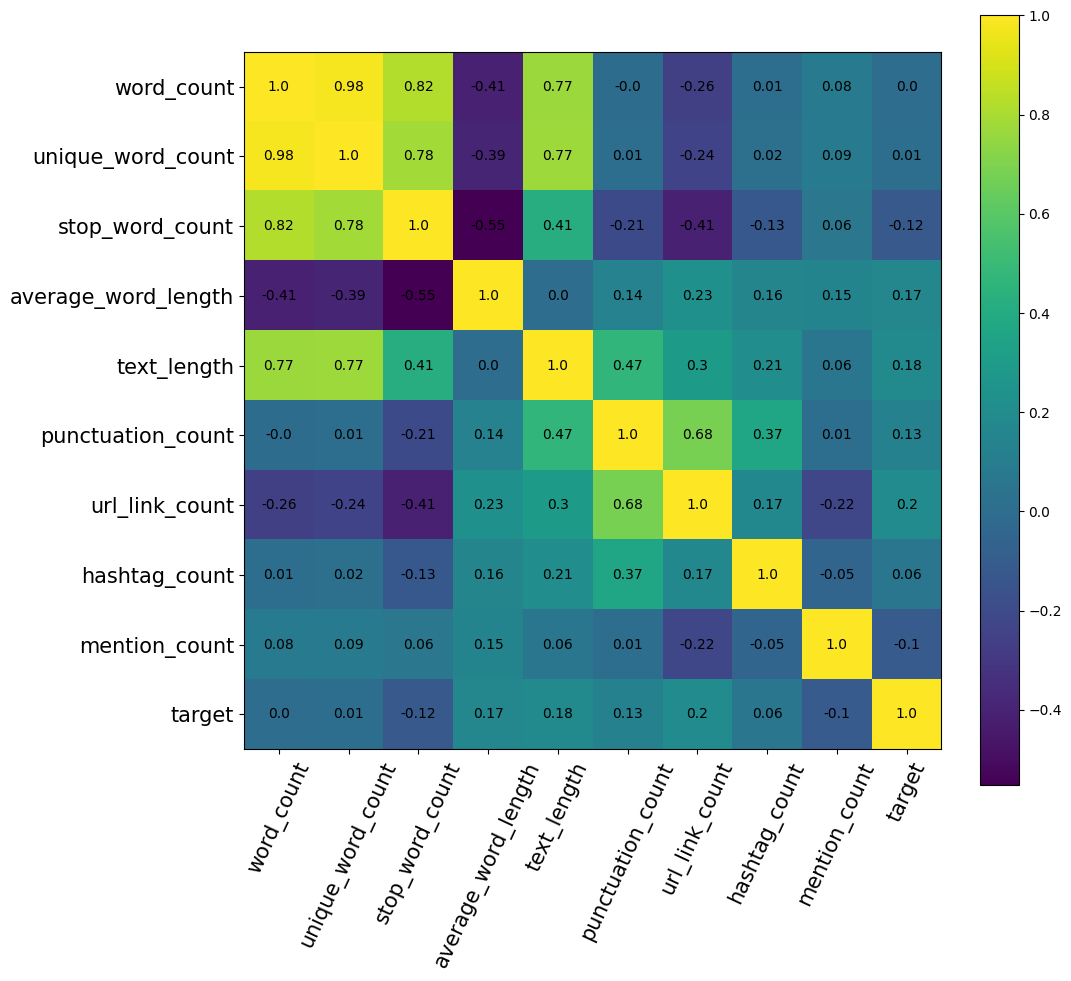

In [ ]:
def draw_heatmap(columns, corr_matrix):
    columns_len = len(columns)
    fig, ax = plt.subplots(figsize=(columns_len, columns_len))
    im = ax.imshow(corr_matrix, interpolation='nearest')
    fig.colorbar(im, orientation='vertical', fraction = 0.05)

    # Show all ticks and label them with the dataframe column name
    ax.set_xticks(range(columns_len))
    ax.set_yticks(range(columns_len))
    ax.set_xticklabels(columns, rotation=65, fontsize=15)
    ax.set_yticklabels(columns, rotation=0, fontsize=15)

    # Loop over data dimensions and create text annotations
    for i in range(columns_len):
        for j in range(columns_len):
            text = ax.text(j, i, round(corr_matrix[i, j], 2),
                        ha="center", va="center", color="black")

    plt.show()

def get_pearson_corr_matrix(columns: str):
    columns_count = len(columns)
    pearson_corr_matrix = np.zeros((columns_count, columns_count))
    for i1, column1 in enumerate(columns):
        for i2, column2 in enumerate(columns):
            pearson_corr_matrix[i1][i2] = df[column1].corr(df[column2], method='pearson')
    return pearson_corr_matrix


columns = NORMALIZED_COLUMNS + ['target']
pearson_corr_matrix = get_pearson_corr_matrix(columns)
draw_heatmap(columns, pearson_corr_matrix)

## Preprocesamiento de Texto y Embeddings <a class="anchor"  id="h1-3"></a>

Se usaron incrustaciones de FastText para representar las palabras en números. Estas representaciones vectoriales capturan información semántica y sintáctica de las palabras. Con la finalidad de que la vectorización funcione mejor, se eliminaron urls, acrónimos y símbolos alcanzando 94% de efectividad.


In [ ]:
from gensim.models.keyedvectors import KeyedVectors

def get_embedding_path(embedding):
    embedding_zoo = {
        "crawl": "../input/fasttext-crawl-300d-2m/crawl-300d-2M.vec",
    }
    return embedding_zoo.get(embedding)

In [ ]:
%%time
crawl_embeddings = KeyedVectors.load_word2vec_format(get_embedding_path('crawl'))

CPU times: user 8min 41s, sys: 4.09 s, total: 8min 45s

Wall time: 9min 16s


In [ ]:
import operator

def get_vocab(X):
    vocab = {}
    texts = X.apply(lambda s: s.split()).values
    for text in texts:
        for word in text:
            try:
                vocab[word] += 1
            except KeyError:
                vocab[word] = 1
    return vocab

def check_embeddings_coverage(X, embeddings):
    vocab = get_vocab(X)
    covered, oov = {}, {}
    n_covered, n_oov = 0, 0

    for word in vocab:
        try:
            covered[word] = embeddings[word]
            n_covered += vocab[word]
        except:
            oov[word] = vocab[word]
            n_oov += vocab[word]

    vocab_coverage = len(covered) / len(vocab)
    text_coverage = (n_covered / (n_covered + n_oov))
    sorted_oov = sorted(oov.items(), key=operator.itemgetter(1))[::-1]
    return sorted_oov, vocab_coverage, text_coverage

In [ ]:
oov, vocab_coverage, text_coverage = check_embeddings_coverage(df['text'], crawl_embeddings)
print(f'Crawl Embeddings cover {vocab_coverage} of vocabulary and {text_coverage} of text')

Crawl Embeddings cover 0.5151923317879965 of vocabulary and 0.8183693075153577 of text


In [ ]:
def remove_url_links(text: str):
    return re.sub(r'http\S+', ' ', text)

def remove_shortened_forms(text: str):
    result = re.sub("won't", ' will not', text)
    result = re.sub("can't", ' can not', text)
    result = re.sub("n't", ' not', text)
    result = re.sub("'m", ' am', text)
    result = re.sub("'re", ' are', text)
    result = re.sub("'ve", ' have', text)
    result = re.sub("'ll", ' will', text)
    result = re.sub("'d", ' would', text)
    result = re.sub("'s", ' ', text)
    return result

def remove_stop_words(text: str):
    stop_words = stopwords.words("english")
    return ' '.join([w for w in text.split() if w not in stop_words])

def preprocessing(text):
    text = str(text).lower()
    text = remove_url_links(text)
    text = remove_shortened_forms(text)
    text = re.sub(r'[^a-z\s]', ' ', text)
    text = remove_stop_words(text)
    text = re.sub('\s+', ' ', text)
    return text

In [ ]:
df['text'] = df['text'].apply(lambda x: preprocessing(x))

oov, vocab_coverage, text_coverage = check_embeddings_coverage(df['text'], crawl_embeddings)
print(f'Crawl Embeddings cover {vocab_coverage} of vocabulary and {text_coverage} of text')

Crawl Embeddings cover 0.7804711293430294 of vocabulary and 0.9382235500272902 of text


In [ ]:
def preprocessing_keywords(df):
    df['keyword'] = df['keyword'].fillna('empty')
    df['keyword'] = df['keyword'].apply(lambda x: x.replace('%20', ' '))
    return df['keyword']

df['keyword'] = preprocessing_keywords(df)

## División del Conjunto de Datos <a class="anchor"  id="**h1**-4"></a>

In [ ]:
import os
import warnings

warnings.filterwarnings("ignore",  category = FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['target'], axis=1), df['target'], test_size=0.04, shuffle=True
)

## Imports

In [ ]:
%%capture
from transformers import TFBertModel, AutoTokenizer

bert = TFBertModel.from_pretrained('bert-large-uncased')
bert_text_tokenizer = AutoTokenizer.from_pretrained('bert-large-uncased')

# <font color="yellow">Entrenamiento del Modelo LSTM <a class="anchor"  id="h2"></a>

## Preparación de entradas <a class="anchor"  id="h2-1"></a>

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences


lstm_text_tokenizer = Tokenizer()
lstm_text_tokenizer.fit_on_texts(X_train['text'])

lstm_keyword_tokenizer = Tokenizer()
lstm_keyword_tokenizer.fit_on_texts(X_train['keyword'])

def prepare_lstm_model_inputs(X):
    seq = lstm_text_tokenizer.texts_to_sequences(X['text'])
    pad_seq = pad_sequences(seq)

    keywords_matrix = lstm_keyword_tokenizer.texts_to_matrix(X['keyword'])
    meta_features = X.loc[:, 'word_count':]
    float_features = np.concatenate([keywords_matrix, meta_features], axis=1)
    return pad_seq, float_features

train_pad_seq, train_float_features = prepare_lstm_model_inputs(X_train)
test_pad_seq, test_float_features = prepare_lstm_model_inputs(X_test)

print(train_pad_seq.shape)
print(train_float_features.shape)

train_pad_seq, train_float_features

(7308, 25)

(7308, 240)


(array([[    0,     0,     0, ...,   509,   301,    63],
        [    0,     0,     0, ...,   451,    10,   498],
        [    0,     0,     0, ...,  6207,   638,   186],
        ...,
        [    0,     0,     0, ...,   346,   990,  3789],
        [    0,     0,     0, ...,     0,   706,  1927],
        [    0,     0,     0, ...,  2653, 15692, 15693]], dtype=int32),
 array([[ 0.        ,  0.        ,  0.        , ...,  0.57216315,
         -0.40459537, -0.501508  ],
        [ 0.        ,  0.        ,  0.        , ...,  0.57216315,
         -0.40459537, -0.501508  ],
        [ 0.        ,  1.        ,  0.        , ...,  0.57216315,
         -0.40459537, -0.501508  ],
        ...,
        [ 0.        ,  0.        ,  0.        , ..., -0.93401876,
         -0.40459537, -0.501508  ],
        [ 0.        ,  0.        ,  0.        , ..., -0.93401876,
         -0.40459537, -0.501508  ],
        [ 0.        ,  0.        ,  0.        , ...,  0.57216315,
         -0.40459537,  2.30067944]]))

In [ ]:
WORD_EMBEDING_LENGTH = len(crawl_embeddings['word'])
VOCAB_SIZE = len(lstm_text_tokenizer.word_index) + 1
INPUT_LENGTH = len(train_pad_seq[0])
INPUT_FLOAT_FEATURES_LENGTH = len(train_float_features[0])

# Converting the words in our Vocabulary to their corresponding embeddings and placing them in a matrix.
embedding_matrix = np.zeros((VOCAB_SIZE, WORD_EMBEDING_LENGTH))
unknown_words = []
for word, i in lstm_text_tokenizer.word_index.items():
    try:
        embedding_vector = crawl_embeddings[word]
        embedding_matrix[i] = embedding_vector
    except KeyError:
        unknown_words.append(word)

print(len(unknown_words))

3386


## Construcción del Modelo LSTM <a class="anchor"  id="h2-2"></a>

In [ ]:
import logging, os
logging.disable(logging.WARNING)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
from tensorflow import keras
import tensorflow_addons as tfa
from tensorflow.keras.layers import *

tf.get_logger().setLevel('INFO')


class LSTMModel:
    def __init__(self):
        self._model = self._build_model()

    @property
    def model(self) -> tf.keras.Model:
        return self._model

    def _build_model(self) -> tf.keras.Model:
        text_input = keras.Input(shape=(None,), name="text")
        x = Embedding(input_dim=VOCAB_SIZE, output_dim=WORD_EMBEDING_LENGTH, weights=[embedding_matrix], input_length=INPUT_LENGTH, trainable = False)(text_input)
        x = SpatialDropout1D(0.4)(x)
        x = LSTM(32, return_sequences=True)(x)
        x = SpatialDropout1D(0.1)(x)
        text_features = LSTM(16)(x)

        float_features_input = keras.Input(shape=(INPUT_FLOAT_FEATURES_LENGTH,), name="float_features")
        x = Dense(64,activation = tf.keras.layers.Activation(tfa.activations.mish))(float_features_input)
        x = Dense(8,activation = tf.keras.layers.Activation(tfa.activations.mish))(x)
        meta_features = Dense(2,activation = tf.keras.layers.Activation(tfa.activations.mish))(x)

        features = concatenate([text_features, meta_features], axis=1)
        x = Dropout(0.2)(features)
        x = Dense(8, activation = tf.keras.layers.Activation(tfa.activations.mish))(x)
        x = Dense(4, activation = tf.keras.layers.Activation(tfa.activations.mish))(x)
        output = Dense(1,activation='sigmoid')(x)

        return keras.Model(inputs=[text_input, float_features_input], outputs=[output])

In [ ]:
model = LSTMModel().model
model.summary()

Model: "model"

__________________________________________________________________________________________________

 Layer (type)                Output Shape                 Param #   Connected to                  


 text (InputLayer)           [(None, None)]               0         []                            

                                                                                                  

 embedding (Embedding)       (None, None, 300)            4708200   ['text[0][0]']                

                                                                                                  

 spatial_dropout1d (Spatial  (None, None, 300)            0         ['embedding[0][0]']           

 Dropout1D)                                                                                       

                                                                                                  

 float_features (InputLayer  [(None, 240)]                0         []             

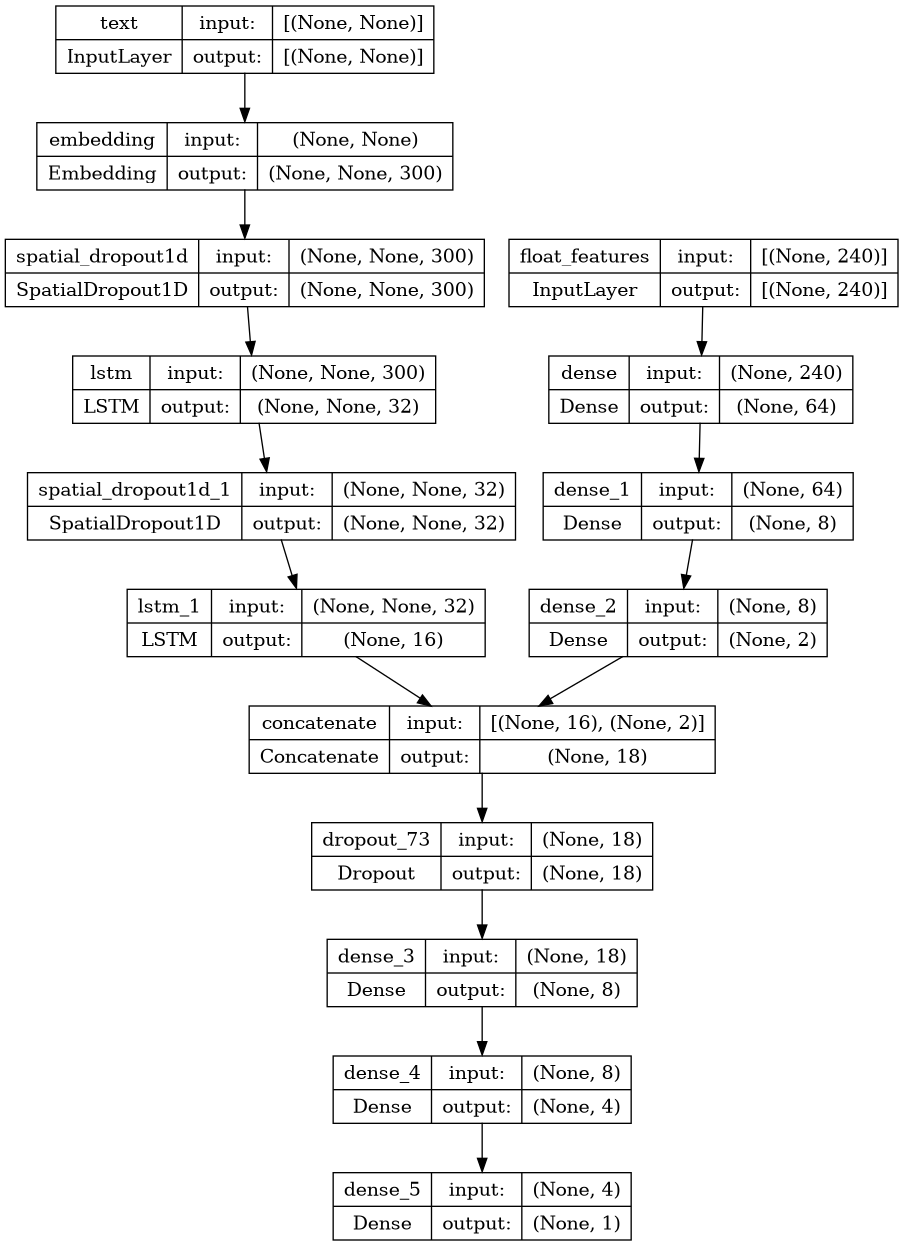

In [ ]:
keras.utils.plot_model(model, "model.png", show_shapes=True)

## Ajuste de Hiperparámetros <a class="anchor"  id="h2-3"></a>

In [ ]:
BATCH_SIZE = 1
EPOCHS_NUMBER = 20
VALIDATION_SPLIT = 0.1
STEPS_PER_EPOCH = int(len(train_pad_seq) // BATCH_SIZE * (1- VALIDATION_SPLIT))

def compile_model(model, learning_rate, warmup_proportion):
    optimizer = tfa.optimizers.RectifiedAdam(
        learning_rate=learning_rate,
        total_steps=EPOCHS_NUMBER * STEPS_PER_EPOCH,
        warmup_proportion=warmup_proportion,
        min_lr=0.0000001,
    )
    optimizer = tfa.optimizers.Lookahead(optimizer)
    model.compile(optimizer=optimizer, loss='binary_crossentropy',
                  metrics = ['accuracy',
                             keras.metrics.Precision(name='precision'),
                             keras.metrics.Recall(name='recall'),
                             tfa.metrics.F1Score(num_classes=2, average='micro', threshold=0.5)]
                 )
    return model


def train_model(learning_rate, warmup_proportion):
    model = LSTMModel().model
    compile_model(model, learning_rate, warmup_proportion)

    checkpoint_filepath = f'/kaggle/working/checkpoints/lstm-model-checkpoint-{learning_rate}-{warmup_proportion}'
    save_callback = keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        monitor='val_f1_score',
        mode='max',
        save_best_only=True
    )


    model_history = model.fit({'text': train_pad_seq, 'float_features': train_float_features},
                              y_train,
                              epochs=EPOCHS_NUMBER,
                              steps_per_epoch=STEPS_PER_EPOCH,
                              validation_split=VALIDATION_SPLIT,
                              callbacks=[save_callback],
                              verbose=1)
    return model_history, checkpoint_filepath

def grid_search(params: list):
    results = []
    best_f1_score = 0
    best_checkpoint_filepath, best_model_history, best_params = None, None, None
    for model_params in params:
        learning_rate = model_params['learning_rate']
        warmup_proportion = model_params['warmup_proportion']
        model_history, checkpoint_filepath = train_model(learning_rate, warmup_proportion)
        f1_score = max(model_history.history['val_f1_score'])
        if f1_score > best_f1_score:
            best_f1_score = f1_score
            best_checkpoint_filepath, best_model_history, best_params = checkpoint_filepath, model_history, model_params
        results.append({'params': model_params, 'model_history': model_history,
                        'checkpoint_filepath': checkpoint_filepath, 'f1_score': f1_score,
                        'best_epoch_index': np.argmax(model_history.history['val_f1_score'])})

    print(results)
    print(f'The best params were found: {best_params}')

    return results, best_checkpoint_filepath, best_model_history, best_params


lstm_all_results, lstm_checkpoint_filepath, lstm_model_history, lstm_best_params = grid_search([
    {'learning_rate': 0.01, 'warmup_proportion': 0.1},
    {'learning_rate': 0.001, 'warmup_proportion': 0.2},
    {'learning_rate': 0.0005, 'warmup_proportion': 0.3},
    {'learning_rate': 0.0001, 'warmup_proportion': 0.3},
])

Epoch 1/20

6577/6577 [==============================] - 103s 14ms/step - loss: 0.5291 - accuracy: 0.7412 - precision: 0.7236 - recall: 0.6335 - f1_score: 0.6756 - val_loss: 0.5125 - val_accuracy: 0.7647 - val_precision: 0.6905 - val_recall: 0.8735 - val_f1_score: 0.7713

Epoch 2/20

6577/6577 [==============================] - 87s 13ms/step - loss: 0.4707 - accuracy: 0.7899 - precision: 0.8104 - recall: 0.6604 - f1_score: 0.7277 - val_loss: 0.4535 - val_accuracy: 0.8071 - val_precision: 0.8399 - val_recall: 0.7108 - val_f1_score: 0.7700

Epoch 3/20

6577/6577 [==============================] - 94s 14ms/step - loss: 0.4465 - accuracy: 0.8008 - precision: 0.7987 - recall: 0.7108 - f1_score: 0.7522 - val_loss: 0.4314 - val_accuracy: 0.8044 - val_precision: 0.8182 - val_recall: 0.7319 - val_f1_score: 0.7727

Epoch 4/20

6577/6577 [==============================] - 87s 13ms/step - loss: 0.4277 - accuracy: 0.8136 - precision: 0.8200 - recall: 0.7197 - f1_score: 0.7666 - val_loss: 0.4587 - v

## Comparación de Hiperparámetros <a class="anchor"  id="h2-4"></a>

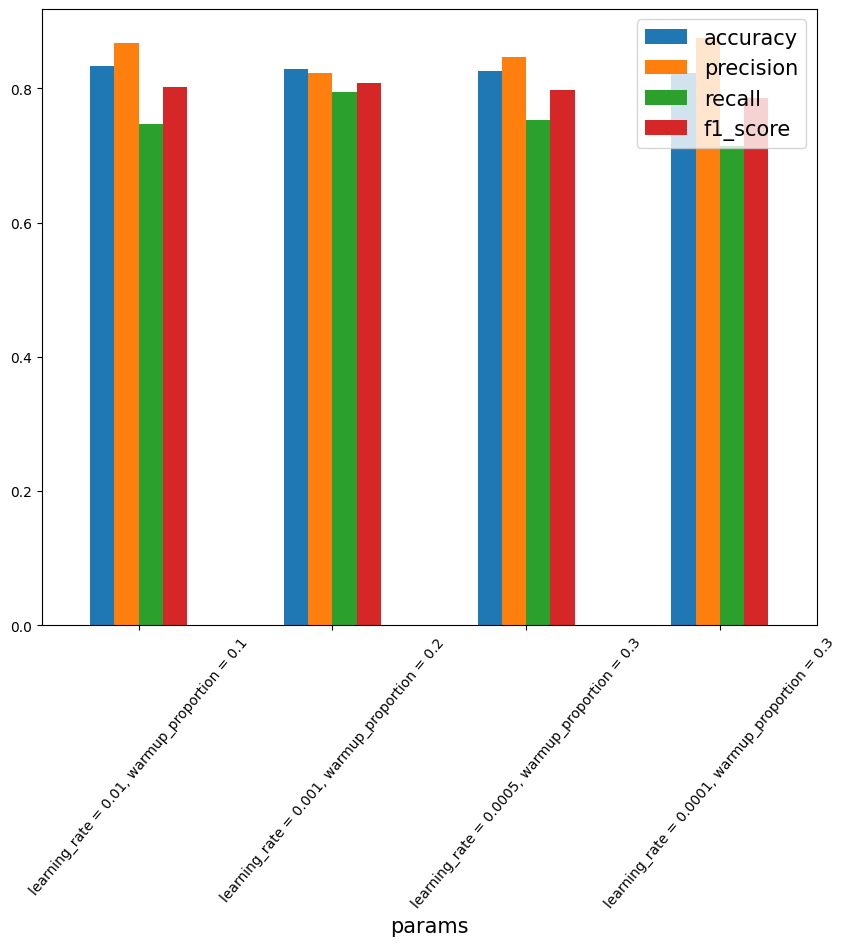

In [ ]:
metrics_results = pd.DataFrame([[
    f"learning_rate = {res['params']['learning_rate']}, warmup_proportion = {res['params']['warmup_proportion']}",
    res['model_history'].history['val_accuracy'][res['best_epoch_index']],
    res['model_history'].history['val_precision'][res['best_epoch_index']],
    res['model_history'].history['val_recall'][res['best_epoch_index']],
    res['model_history'].history['val_f1_score'][res['best_epoch_index']],
] for res in lstm_all_results], columns=['params', 'accuracy', 'precision', 'recall', 'f1_score'])

fig, ax = plt.subplots()
metrics_results.plot.bar(ax=ax, x='params', figsize=(10, 8), rot=50)
ax.set_xlabel('params', fontsize=15)
ax.legend(prop={'size': 15})

## Análisis de Resultados <a class="anchor"  id="h4-4"></a>

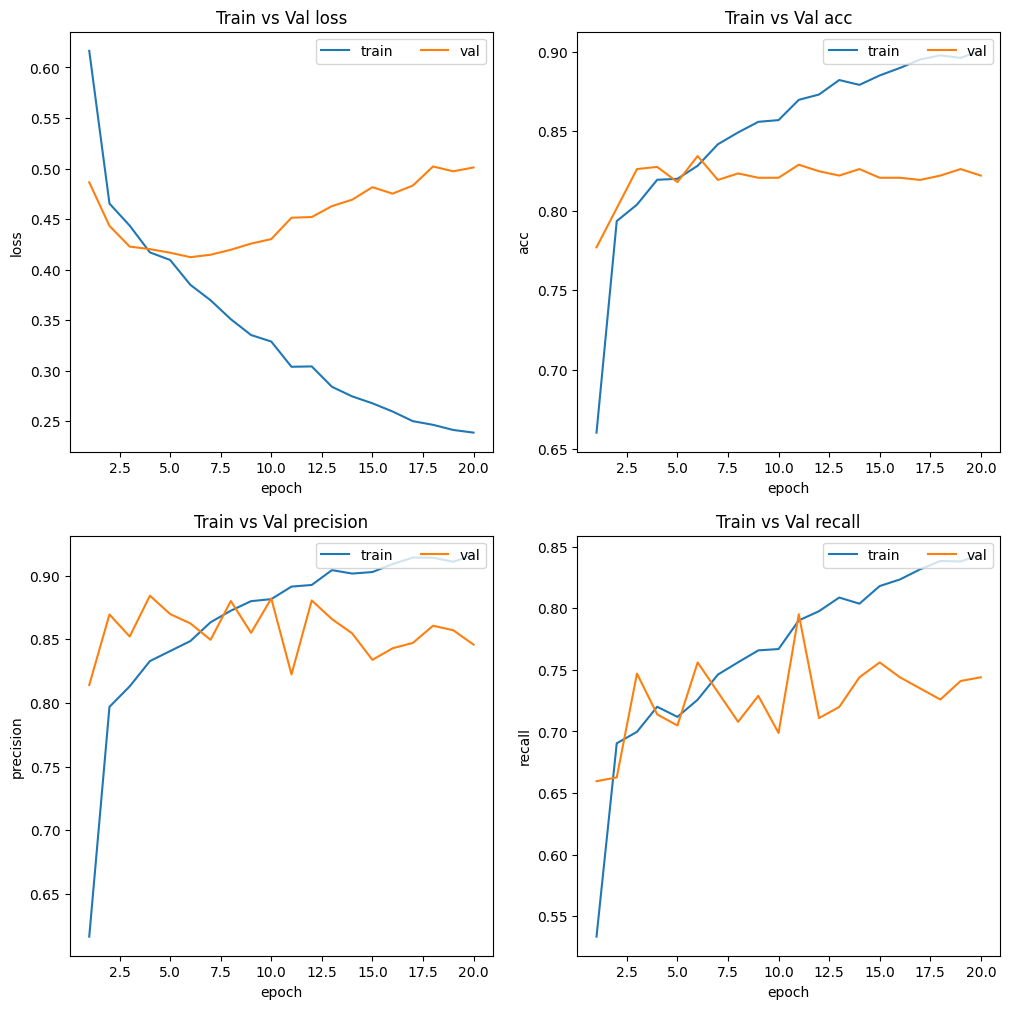

In [ ]:
def make_plot(loss, val_loss, acc, val_acc, precision, val_precision, recall, val_recall):
    t = np.arange(1,len(loss)+1,1)

    f, axs = plt.subplots(2, 2, figsize=(12,12))
    plt.subplots_adjust(wspace=0.2)

    axs[0,0].plot(t, loss)
    axs[0,0].plot(t, val_loss)
    axs[0,0].set_xlabel('epoch')
    axs[0,0].set_ylabel('loss')
    axs[0,0].set_title('Train vs Val loss')
    axs[0,0].legend(['train','val'], ncol=2, loc='upper right')

    axs[0,1].plot(t, acc)
    axs[0,1].plot(t, val_acc)
    axs[0,1].set_xlabel('epoch')
    axs[0,1].set_ylabel('acc')
    axs[0,1].set_title('Train vs Val acc')
    axs[0,1].legend(['train','val'], ncol=2, loc='upper right')

    axs[1,0].plot(t, precision)
    axs[1,0].plot(t, val_precision)
    axs[1,0].set_xlabel('epoch')
    axs[1,0].set_ylabel('precision')
    axs[1,0].set_title('Train vs Val precision')
    axs[1,0].legend(['train','val'], ncol=2, loc='upper right')

    axs[1,1].plot(t, recall)
    axs[1,1].plot(t, val_recall)
    axs[1,1].set_xlabel('epoch')
    axs[1,1].set_ylabel('recall')
    axs[1,1].set_title('Train vs Val recall')
    axs[1,1].legend(['train','val'], ncol=2, loc='upper right')

    plt.show()

loss = lstm_model_history.history['loss']
acc = lstm_model_history.history['accuracy']
precision = lstm_model_history.history['precision']
recall = lstm_model_history.history['recall']
val_loss = lstm_model_history.history['val_loss']
val_acc = lstm_model_history.history['val_accuracy']
val_precision = lstm_model_history.history['val_precision']
val_recall = lstm_model_history.history['val_recall']

make_plot(loss, val_loss, acc, val_acc, precision, val_precision, recall, val_recall)

In [ ]:
model = LSTMModel().model
model.load_weights(lstm_checkpoint_filepath)
compile_model(model, lstm_best_params['learning_rate'], lstm_best_params['warmup_proportion'])

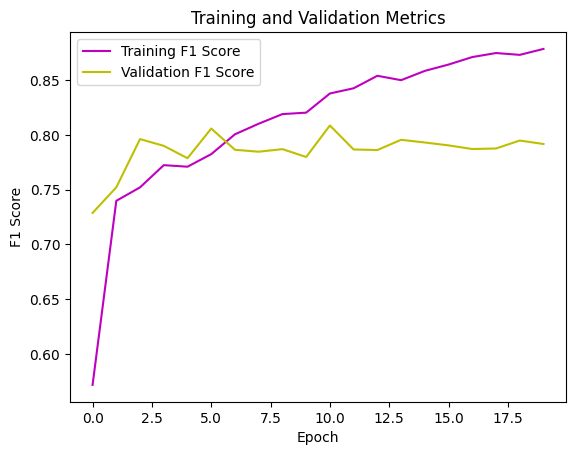

In [ ]:
f1_score = lstm_model_history.history['f1_score']
val_f1_score = lstm_model_history.history['val_f1_score']

plt.figure()
plt.plot(lstm_model_history.epoch, f1_score, 'm', label='Training F1 Score')
plt.plot(lstm_model_history.epoch, val_f1_score, 'y', label='Validation F1 Score')

plt.title('Training and Validation Metrics')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()
plt.show()

The focus of the work was on developing a deep learning model for the classification of posts related to disasters. The accuracy of the classification achieved 80%, indicating the effectiveness of the proposed approach.